# Import Libs

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocessing

In [71]:
# Import dataset
data = pd.read_excel('dataset_norm.xlsx')
data_raw_copy = data

# Define minimal mark
min_mark = 4

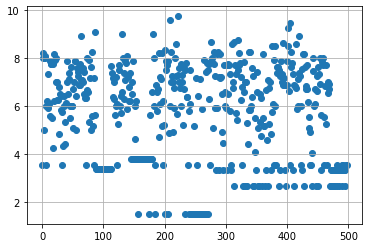

In [72]:
# Output distribution of scores
x = range(len(data['Средний балл']))
y = data['Средний балл']

plt.scatter(x, y)
plt.grid()
plt.show()

NOTE: lines in graph illustrate custom increase the number of not pass students.
That trick were done for better model training. It helps to increase accuracy metricks of models

Lets find out how many students did not pass the exams

In [73]:
def counter_print():
    passed = 0
    not_passed = 0
    res = 0
    for mark in data['Средний балл']:
        if mark >= min_mark:
            passed += 1
        elif mark < min_mark:
            not_passed += 1
        res += 1
    print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")

counter_print()

TOTAL: 498
Passed: 341
Not pas: 157


In [74]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data.drop(['Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?',
            '13.На какие средства Вы живете?',
            '5.Брали ли Вы академический отпуск?',
            '17.Укажите Ваше семейное положение.',
            '12.Каковы условия Вашего проживания?'
            ],
            axis = 1, inplace = True)

Dataset with concern questions

In [75]:
data.head()

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
0,Кайнов Кирилл Анатольевич,Нет,"да, хожу на фитнес или в тренажерный зал",От 1 до 3 часов в день,Среднее количество пропусков,1-2 раза в семестр,нет,Нет,0
1,Матутин Василий Андреевич,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,"Нет, но собираюсь в этом году",1
2,Константинов Александр Михайлович,Да,"нет, не занимаюсь",Готовлюсь только перед занятиями,Регулярно пропускаете,Всегда,нет,Нет,1
3,Кудакаев Руслан Фаритович,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,Нет,1
4,Балов Илья Сергеевич,Нет,"да, занимаюсь шахматами/шашками;нет, не занимаюсь",Более 3 часов в день,Среднее количество пропусков,1-2 раза в год,нет,Да,1


Split our data in 3 parts for train, test and validation

In [76]:
# Save hash of student name
name_hash = []


def train_test_val_split(test_ratio, validation_ratio):
# That part index all names to use them in validation part
    global name_hash
    for idx, name in enumerate(data['Учащийся']):
        name_hash.append((idx, name))
        data.loc[idx:,0] = idx  # data['Учащийся'][idx] = idx


# Replace all text output to index
    label_encoder = LabelEncoder()
    s = (data.dtypes == 'object')
    object_cols = list(s[s].index)
    label_data = data.copy()
    for col in object_cols:
        label_encoder.fit(data[col])
        label_data[col] = label_encoder.transform(data[col])

# Split dataset
    size = data.shape[0]
    validation_ratio = (validation_ratio * size) / (size * (1 - test_ratio))
    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=test_ratio,
                                                        random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(  X_train,
                                                        y_train, 
                                                        test_size=validation_ratio, 
                                                        random_state=1)

# Output X_train.iloc[:,1:] delete student hash from training and testing selections
    return X_train.iloc[:,1:], X_test.iloc[:,1:], X_val, y_train, y_test, y_val

In [77]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(test_ratio=0.25, validation_ratio=0.01)

# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [78]:
def classification_quality(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1:", f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:", (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [79]:
# For historical reason
def regression_quality(y_test, y_pred):
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))

In [80]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # Classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for _ in range(4): temp_array.append(None)
    
    # For historical reason
    elif model_flag == 'reg': # Regression
        return
        for _ in range(5): temp_array.append(None)
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for _ in range(len(metrics_list)): temp_array.append(None)

    model_indx = -1
    flag = 1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [81]:
def graph_show(model, X, y):
    metrics.plot_confusion_matrix(model, X, y)
    metrics.plot_roc_curve(model, X, y)  
    plt.show()

## Classifier

### Perception Classifier Model

In [82]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')

Accuracy: 0.72
Recall: 0.5583538083538084
Precision: 0.6652173913043478
F1: 0.5414526779163611
Weighted Recall: (0.6652173913043478, 0.5583538083538084, 0.5414526779163611, None)


### Random Forest Classifier Model

In [83]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
Weighted Recall: (1.0, 1.0, 1.0, None)


### Gradient Boosting Classifier Model

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
GraB = GradientBoostingClassifier()
GraB.fit(X_train, y_train)

y_pred = GraB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GradientBoosting', y_test, y_pred, 'cls')

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
Weighted Recall: (1.0, 1.0, 1.0, None)


### MultinomialNB Classifier Model

In [85]:
from sklearn.naive_bayes import MultinomialNB
MulNB = MultinomialNB()
MulNB.fit(X_train, y_train)

y_pred = MulNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MultinomialNB', y_test, y_pred, 'cls')

Accuracy: 0.68
Recall: 0.686578624078624
Precision: 0.6577922077922078
F1: 0.6560264171711613
Weighted Recall: (0.6577922077922078, 0.686578624078624, 0.6560264171711613, None)


### ComplementNB Classifier Model

In [86]:
from sklearn.naive_bayes import ComplementNB
ComNB = ComplementNB()
ComNB.fit(X_train, y_train)

y_pred = ComNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('ComplementNB', y_test, y_pred, 'cls')

Accuracy: 0.664
Recall: 0.6752149877149878
Precision: 0.64718782249742
F1: 0.6419803600654664
Weighted Recall: (0.64718782249742, 0.6752149877149878, 0.6419803600654664, None)


### GaussianNB Classifier Model

In [87]:
from sklearn.naive_bayes import GaussianNB
GaNB = GaussianNB()
GaNB.fit(X_train, y_train)

y_pred = GaNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GaussianNB', y_test, y_pred, 'cls')

Accuracy: 0.944
Recall: 0.9602272727272727
Precision: 0.9204545454545454
F1: 0.9360800642851925
Weighted Recall: (0.9204545454545454, 0.9602272727272727, 0.9360800642851925, None)


### BernoulliNB Classifier Model

In [88]:
from sklearn.naive_bayes import BernoulliNB
BerNB = BernoulliNB()
BerNB.fit(X_train, y_train)

y_pred = BerNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('BernoulliNB', y_test, y_pred, 'cls')

Accuracy: 0.888
Recall: 0.9204545454545454
Precision: 0.8627450980392157
F1: 0.8772446689113356
Weighted Recall: (0.8627450980392157, 0.9204545454545454, 0.8772446689113356, None)


### SVC Classifier Model

In [89]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('SVC', y_test, y_pred, 'cls')

Accuracy: 0.704
Recall: 0.5
Precision: 0.352
F1: 0.8262910798122065
Weighted Recall: (0.352, 0.5, 0.41314553990610325, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LinearSVC Classifier Model

In [90]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('LinearSVC', y_test, y_pred, 'cls')

Accuracy: 0.584
Recall: 0.7045454545454546
Precision: 0.7078651685393258
F1: 0.583973374295955
Weighted Recall: (0.7078651685393258, 0.7045454545454546, 0.583973374295955, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### DecisionTreeClassifier Model

In [91]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 0.992
Recall: 0.9864864864864865
Precision: 0.9943820224719101
F1: 0.9903258261744448
Weighted Recall: (0.9943820224719101, 0.9864864864864865, 0.9903258261744448, None)


### ExtraTreeClassifier Model

Accuracy: 0.984
Recall: 0.9886363636363636
Precision: 0.9743589743589743
F1: 0.9810949788263763
Weighted Recall: (0.9743589743589743, 0.9886363636363636, 0.9810949788263763, None)


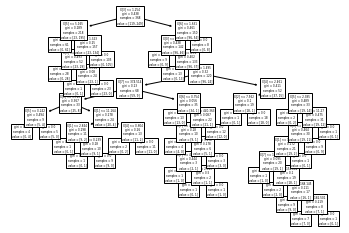

In [92]:
from sklearn.tree import plot_tree, ExtraTreeClassifier
extr = ExtraTreeClassifier()
extr.fit(X_train, y_train)

y_pred = extr.predict(X_test)

plot_tree(extr)
classification_quality(y_test, y_pred)
compilance_print('ExtraTreeClassifier', y_test, y_pred, 'cls')

### MLPClassifier Model

In [93]:
from sklearn.neural_network import MLPClassifier
MLPCl = MLPClassifier()
MLPCl.fit(X_train, y_train)

y_pred = MLPCl.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MLPClassifier', y_test, y_pred, 'cls')

Accuracy: 0.952
Recall: 0.9659090909090908
Precision: 0.9302325581395349
F1: 0.9448529411764706
Weighted Recall: (0.9302325581395349, 0.9659090909090908, 0.9448529411764706, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Matrix
That table helps to understand which model is better for my work

In [94]:
pd.DataFrame(index=metrics_list, columns=model_array, data=np.array(pd.DataFrame(output_array).T))

,Perceptron,RandomForest,GradientBoosting,MultinomialNB,ComplementNB,GaussianNB,BernoulliNB,SVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,MLPClassifier
Accuracy,0.72,1.0,1.0,0.68,0.664,0.944,0.888,0.704,0.584,0.992,0.984,0.952
Balanced Accuracy,0.558354,1.0,1.0,0.686579,0.675215,0.960227,0.920455,0.5,0.704545,0.986486,0.988636,0.965909
Recall,0.558354,1.0,1.0,0.686579,0.675215,0.960227,0.920455,0.5,0.704545,0.986486,0.988636,0.965909
Precision,0.665217,1.0,1.0,0.657792,0.647188,0.920455,0.862745,0.352,0.707865,0.994382,0.974359,0.930233
F1,0.541453,1.0,1.0,0.656026,0.64198,0.93608,0.877245,0.826291,0.583973,0.990326,0.981095,0.944853
MSE,None,None,None,None,None,None,None,None,None,None,None,None
RMSE,None,None,None,None,None,None,None,None,None,None,None,None
MAE,None,None,None,None,None,None,None,None,None,None,None,None
R2,None,None,None,None,None,None,None,None,None,None,None,None


# Model result

I decided to use model X due to its metrix

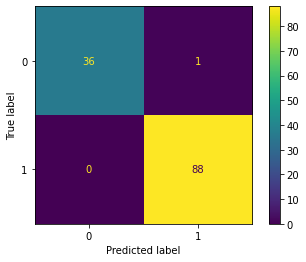

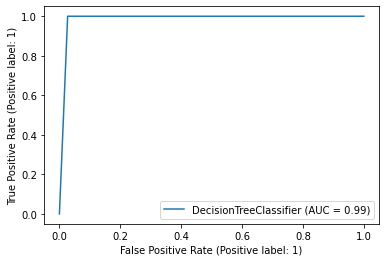

In [95]:
my_model = dtr

# ROC/AUC graphs
graph_show(my_model, X_test, y_test)

# Validation

In [96]:
# Get predicted results of validation selection
# NOTE: Validation selection was not used for training model thus the results are objective
y_pred_val = my_model.predict(X_val.iloc[:,1:])

In [97]:
error_counter = 0
total = 0
for i in range(len(y_pred_val)):
    if y_pred_val[i] != y_val.iloc[i] == 1:
        error_counter += 1
    total += 1
    print(f'Студент {name_hash[X_val.iloc[i, 0]][1]} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')
print(f'There were {error_counter} from {total} error(s)!')

Студент Воробьев Дмитрий Максимович предположительно сдал(а), в жизни сдал(а)
Студент Мещерин Антон Андреевич предположительно сдал(а), в жизни сдал(а)
Студент Некравцев Алексей Александрович предположительно сдал(а), в жизни сдал(а)
Студент Кашина Елизавета Андреевна предположительно сдал(а), в жизни сдал(а)
Студент Лакеев Денис Максимович предположительно не сдал(а), в жизни не сдал(а)
There were 0 from 5 error(s)!
